In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import openke
from openke.config import Trainer, Tester
from openke.module.loss import SigmoidLoss
from openke.module.strategy import NegativeSampling
from openke.data import TrainDataLoader, TestDataLoader

from models import RotAtte

In [3]:
import torch
import numpy as np

In [4]:
negative_rate = 10
batch_size=1000

In [5]:
train_dataloader = TrainDataLoader(
	in_path = "./benchmarks/FB15K237/", 
	batch_size = batch_size,
	threads = 1,
	sampling_mode = "cross", 
	bern_flag = 0, 
	filter_flag = 1, 
	neg_ent = negative_rate,
	neg_rel = 0
)

facts = TrainDataLoader(
	in_path = "./benchmarks/FB15K237/", 
	batch_size = train_dataloader.get_triple_tot(),
	threads = 1,
	sampling_mode = "normal", 
	bern_flag = 0, 
	filter_flag = 1, 
	neg_ent = 0,
	neg_rel = 0
)

h, t, r, _, _ = [f for f in facts][0].values()
h = torch.Tensor(h).to(torch.long)
t = torch.Tensor(t).to(torch.long)
r = torch.Tensor(r).to(torch.long)

facts = torch.stack((h, r, t)).cuda().t()
test_dataloader = TestDataLoader("./benchmarks/FB15K237/", "link")

n_ent = train_dataloader.get_ent_tot()
n_rel = train_dataloader.get_rel_tot()

In [6]:
in_dim = 50
out_dim = 50
n_heads = 2
type_ = "split"

In [12]:
from models import RotAtte

In [13]:
rotatte = RotAtte(n_ent, n_rel, in_dim, out_dim, facts, n_heads, batch_size=batch_size)

In [14]:
model = NegativeSampling(
	model = rotatte, 
	loss = SigmoidLoss(adv_temperature = 2),
	batch_size = train_dataloader.get_batch_size(), 
	regul_rate = 0.0
)

In [15]:
trainer = Trainer(model = model, data_loader = train_dataloader, train_times = 100, alpha = 2e-5, use_gpu = True, opt_method = "adam")

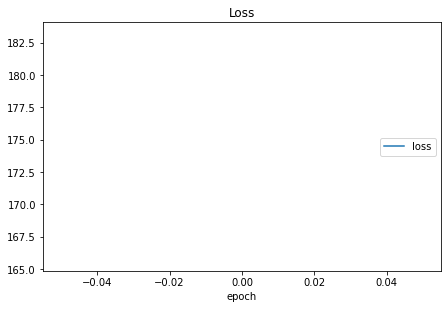

100%|██████████| 1/1 [01:23<00:00, 83.22s/it]

Loss
	loss             	 (min:  174.461, max:  174.461, cur:  174.461)


In [16]:
trainer.run(2e-3, train_times=1)